In [1]:
import os
import time
import math
import random
import pickle
import shutil
import warnings

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from drift_detectors import *
from forecasters import *
from autoencoder import *
from utils import *
from data import *

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

In [2]:
# Set a global seed for reproducibility
seed = 42

# Seed Python, NumPy, and PyTorch RNGs
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Create and seed a PyTorch Generator (for Dataloaders)
g= torch.Generator()
g.manual_seed(seed)

# Seed CUDA (if available)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior in cuDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Directory paths for saving and loading components
AE_DIR = "trained_autoencoders"
FORECASTERS_DIR= "trained_forecasters"
RESULTS_DIR = "results"

# Size of the autoencoder bottleneck
latent_dim = 2

# Dataset configurations: (Name, Class, Sequence Length, Window Size)
ts_configs = [
    ("Sudden", Sudden, None, 10),
    ("Gradual", Gradual, None, 10),
    ("Mixed", Mixed, None, 10),
]

# Flags to toggle use of autoencoder embeddings
autoencoder_embedding_flags = [False, True]

# Distance metrics to evaluate
metrics_list = ["dtw", "euclidean", "cosine", "manhattan"]

# Set device for computation (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda



Training AE on Sudden (window_size=10)
  Epoch 1/30 — loss: 0.574753
  Epoch 2/30 — loss: 0.271616
  Epoch 3/30 — loss: 0.212320
  Epoch 4/30 — loss: 0.185262
  Epoch 5/30 — loss: 0.164091
  Epoch 6/30 — loss: 0.156946
  Epoch 7/30 — loss: 0.140132
  Epoch 8/30 — loss: 0.132005
  Epoch 9/30 — loss: 0.121326
  Epoch 10/30 — loss: 0.114960
  Epoch 11/30 — loss: 0.111557
  Epoch 12/30 — loss: 0.103569
  Epoch 13/30 — loss: 0.103588
  Epoch 14/30 — loss: 0.099164
  Epoch 15/30 — loss: 0.092631
  Epoch 16/30 — loss: 0.093263
  Epoch 17/30 — loss: 0.090138
  Epoch 18/30 — loss: 0.088938
  Epoch 19/30 — loss: 0.082105
  Epoch 20/30 — loss: 0.083977
  Epoch 21/30 — loss: 0.081950
  Epoch 22/30 — loss: 0.080923
  Epoch 23/30 — loss: 0.080155
  Epoch 24/30 — loss: 0.076836
  Epoch 25/30 — loss: 0.076347
  Epoch 26/30 — loss: 0.073591
  Epoch 27/30 — loss: 0.070701
  Epoch 28/30 — loss: 0.069818
  Epoch 29/30 — loss: 0.069399
  Epoch 30/30 — loss: 0.067835
Saved AE: trained_autoencoders\ae_Sudde

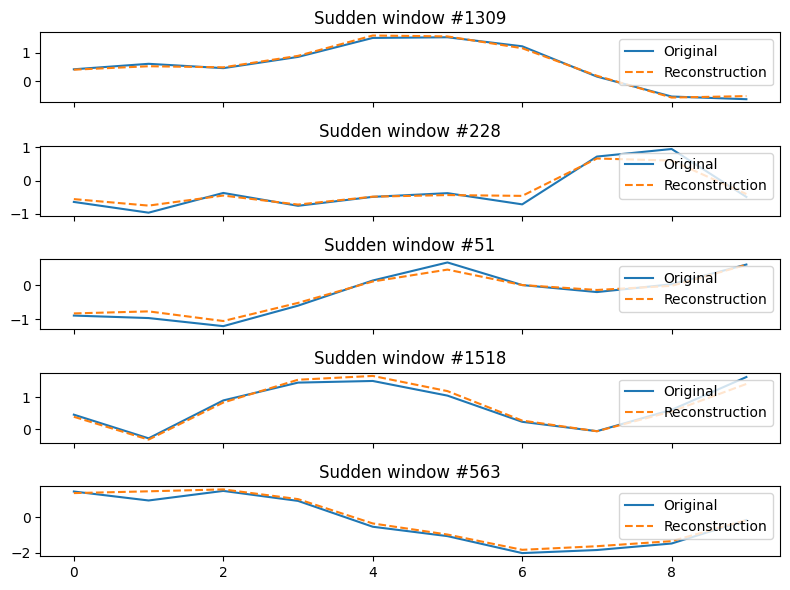


Training AE on Gradual (window_size=10)
  Epoch 1/30 — loss: 0.538666
  Epoch 2/30 — loss: 0.233888
  Epoch 3/30 — loss: 0.185620
  Epoch 4/30 — loss: 0.162625
  Epoch 5/30 — loss: 0.147122
  Epoch 6/30 — loss: 0.132851
  Epoch 7/30 — loss: 0.126747
  Epoch 8/30 — loss: 0.121643
  Epoch 9/30 — loss: 0.113677
  Epoch 10/30 — loss: 0.108387
  Epoch 11/30 — loss: 0.104639
  Epoch 12/30 — loss: 0.099450
  Epoch 13/30 — loss: 0.096878
  Epoch 14/30 — loss: 0.091250
  Epoch 15/30 — loss: 0.092871
  Epoch 16/30 — loss: 0.089804
  Epoch 17/30 — loss: 0.090868
  Epoch 18/30 — loss: 0.087063
  Epoch 19/30 — loss: 0.082739
  Epoch 20/30 — loss: 0.081958
  Epoch 21/30 — loss: 0.081345
  Epoch 22/30 — loss: 0.080113
  Epoch 23/30 — loss: 0.079795
  Epoch 24/30 — loss: 0.080183
  Epoch 25/30 — loss: 0.075201
  Epoch 26/30 — loss: 0.073457
  Epoch 27/30 — loss: 0.075201
  Epoch 28/30 — loss: 0.074311
  Epoch 29/30 — loss: 0.077181
  Epoch 30/30 — loss: 0.074531
Saved AE: trained_autoencoders\ae_Grad

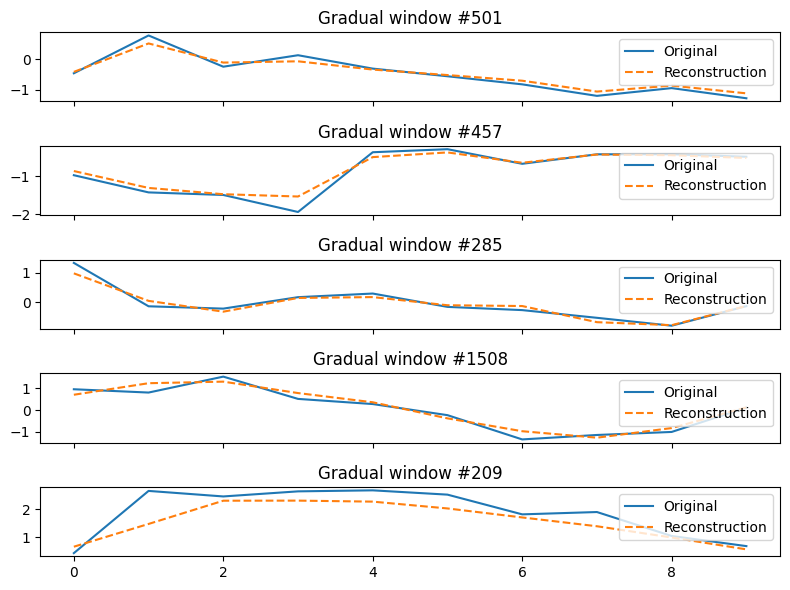


Training AE on Mixed (window_size=10)
  Epoch 1/30 — loss: 0.510914
  Epoch 2/30 — loss: 0.272424
  Epoch 3/30 — loss: 0.227971
  Epoch 4/30 — loss: 0.201602
  Epoch 5/30 — loss: 0.177413
  Epoch 6/30 — loss: 0.160973
  Epoch 7/30 — loss: 0.144662
  Epoch 8/30 — loss: 0.131378
  Epoch 9/30 — loss: 0.122826
  Epoch 10/30 — loss: 0.119471
  Epoch 11/30 — loss: 0.110100
  Epoch 12/30 — loss: 0.109834
  Epoch 13/30 — loss: 0.102321
  Epoch 14/30 — loss: 0.101082
  Epoch 15/30 — loss: 0.097902
  Epoch 16/30 — loss: 0.095340
  Epoch 17/30 — loss: 0.092927
  Epoch 18/30 — loss: 0.088754
  Epoch 19/30 — loss: 0.087379
  Epoch 20/30 — loss: 0.086508
  Epoch 21/30 — loss: 0.083280
  Epoch 22/30 — loss: 0.081354
  Epoch 23/30 — loss: 0.080291
  Epoch 24/30 — loss: 0.081120
  Epoch 25/30 — loss: 0.079842
  Epoch 26/30 — loss: 0.073475
  Epoch 27/30 — loss: 0.074663
  Epoch 28/30 — loss: 0.072648
  Epoch 29/30 — loss: 0.071104
  Epoch 30/30 — loss: 0.072024
Saved AE: trained_autoencoders\ae_Mixed.

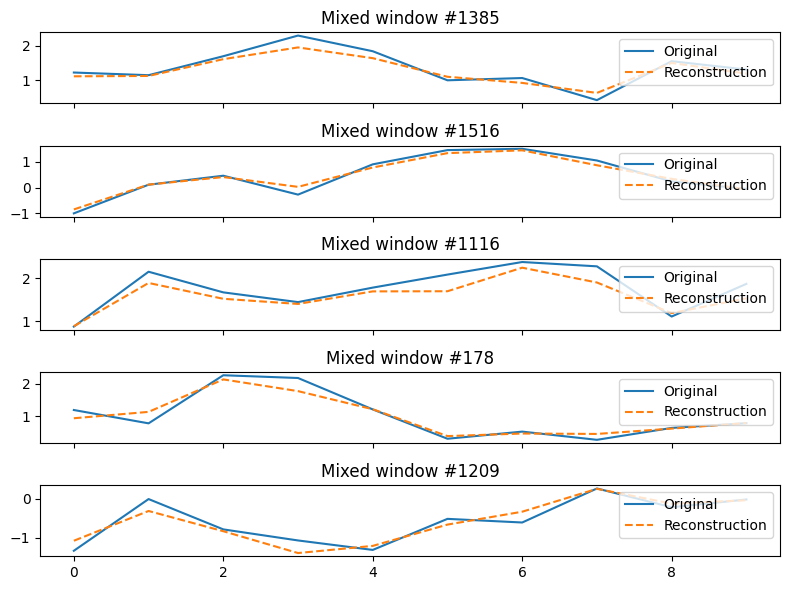

In [4]:
# Autoencoder Training Settings
epochs    = 30
lr        = 1e-3
dropout_p = 0.3

# Ensure a clean autoencoders/ directory
if os.path.exists(AE_DIR):
    shutil.rmtree(AE_DIR)
os.makedirs(AE_DIR, exist_ok=True)

for ds_name, DS, length, window_size in ts_configs:
    print(f"\nTraining AE on {ds_name} (window_size={window_size})")
    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    
    
    # model + optimizer + loss
    ae        = ConvAutoencoder1D(window_size, latent_dim, dropout_p).to(device)
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # wrap as DataLoader of shape (batch, 1, window_size)
    ds_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float).unsqueeze(1)),
        batch_size=128, 
        shuffle=True, 
        generator= g
    )
    
    # training loop
    for epoch in range(1, epochs + 1):
        losses = []
        ae.train()
        for (batch_x,) in ds_loader:
            batch_x = batch_x.to(device)
            recon   = ae(batch_x)
            loss    = criterion(recon, batch_x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f"  Epoch {epoch}/{epochs} — loss: {np.mean(losses):.6f}")
    
    # save per‐dataset autoencoder
    ckpt_path = os.path.join(AE_DIR, f"ae_{ds_name}.pth")
    torch.save(ae.state_dict(), ckpt_path)
    print(f"Saved AE: {ckpt_path}")

    # 6. Visualize reconstructions in eval mode
    ae.eval()
    sample_idxs = random.sample(range(len(X_val)), 5)
    fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
    for ax, idx in zip(axes, sample_idxs):
        orig = X_train[idx]
        with torch.no_grad():
            inp = torch.tensor(orig, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
            recon = ae(inp).cpu().squeeze().numpy()
        ax.plot(orig, label="Original")
        ax.plot(recon, linestyle="--", label="Reconstruction")
        ax.set_title(f"{ds_name} window #{idx}")
        ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

In [5]:
# Ensure a clean forecasters/ directory
if os.path.exists(FORECASTERS_DIR):
    shutil.rmtree(FORECASTERS_DIR)
os.makedirs(FORECASTERS_DIR, exist_ok=True)

for ds_name, DS, length, window_size in ts_configs:
    print(f"\n→ Dataset: {ds_name} (window_size={window_size})")

    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    forecasters = {
    "ARIMA": ARIMAForecaster(),
    "ExpSmoothing": ExpSmoothingForecaster(),
    "LinearRegression": LinearRegressionForecaster(),
    "RandomForest": RandomForestForecaster(random_state=seed),
    "SVR": SVRForecaster(),
    "GradientBoosting": GradientBoostingForecaster(random_state=seed),
    "DT": DecisionTreeForecaster(random_state=seed),
    "MLP1": MLPForecaster(hidden_layer_sizes=(64,), random_state=seed),
    "MLP2": MLPForecaster(hidden_layer_sizes=(64, 32), random_state=seed),
    "MLP3": MLPForecaster(hidden_layer_sizes=(128, 64, 32), random_state=seed),
    "LSTM1": LSTMForecaster(),
    "LSTM2": LSTMForecaster(num_layers=2),
    "LSTM3": LSTMForecaster(num_layers=3),
    "BiLSTM1": BiLSTMForecaster(),
    "BiLSTM2": BiLSTMForecaster(num_layers=2),
    "BiLSTM3": BiLSTMForecaster(num_layers=3),
    "CNNLSTM1": CNNLSTMForecaster(),
    "CNNLSTM2": CNNLSTMForecaster(lstm_num_layers=2),
    "CNNLSTM3": CNNLSTMForecaster(lstm_num_layers=3),
    }

    for name, model in forecasters.items():
        print(f"    → Training {name}…", end=" ")
        model.fit(X_train, y_train, generator=g)

        # save the entire model object as a .pkl
        save_path = os.path.join(FORECASTERS_DIR, f"{ds_name}_{name}.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(model, f)
        print(f"DONE")


→ Dataset: Sudden (window_size=10)
    → Training ARIMA… DONE
    → Training ExpSmoothing… DONE
    → Training LinearRegression… DONE
    → Training RandomForest… DONE
    → Training SVR… DONE
    → Training GradientBoosting… DONE
    → Training DT… DONE
    → Training MLP1… DONE
    → Training MLP2… DONE
    → Training MLP3… DONE
    → Training LSTM1… 1/30 0.85001 | 15/30 0.37285 | 30/30 0.36967 | DONE
    → Training LSTM2… 1/30 0.83279 | 15/30 0.37781 | 30/30 0.37292 | DONE
    → Training LSTM3… 1/30 0.88272 | 15/30 0.37616 | 30/30 0.37642 | DONE
    → Training BiLSTM1… 1/30 0.82092 | 15/30 0.37117 | 30/30 0.37010 | DONE
    → Training BiLSTM2… 1/30 0.70600 | 15/30 0.37186 | 30/30 0.37115 | DONE
    → Training BiLSTM3… 1/30 0.73588 | 15/30 0.37285 | 30/30 0.37491 | DONE
    → Training CNNLSTM1… 1/30 0.67296 | 15/30 0.38465 | 30/30 0.38009 | DONE
    → Training CNNLSTM2… 1/30 0.74921 | 15/30 0.38368 | 30/30 0.37997 | DONE
    → Training CNNLSTM3… 1/30 0.78772 | 15/30 0.38883 | 30/30 

In [6]:
os.makedirs(AE_DIR, exist_ok=True)
os.makedirs(FORECASTERS_DIR, exist_ok=True)

loaded = {}
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n→ Loading models for {ds_name} (window_size={window_size})")
    
    # Load Autoencoder
    ae = ConvAutoencoder1D(window_size, latent_dim, dropout_p).eval().to(device)
    ae_ckpt = os.path.join(AE_DIR, f"ae_{ds_name}.pth")
    ae.load_state_dict(torch.load(ae_ckpt, map_location=device))
    print(f"     AE loaded from {AE_DIR}{os.sep}")
    
    # Load Forecasters
    forecasters = {}
    for name in [
        "ARIMA",
        "ExpSmoothing",
        "LinearRegression",
        "RandomForest",
        "SVR",
        "GradientBoosting",
        "DT",
        "MLP1",
        "MLP2",
        "MLP3",
        "LSTM1",
        "LSTM2",
        "LSTM3",
        "BiLSTM1",
        "BiLSTM2",
        "BiLSTM3",
        "CNNLSTM1",
        "CNNLSTM2",
        "CNNLSTM3",
    ]:
        pkl_path = os.path.join(FORECASTERS_DIR, f"{ds_name}_{name}.pkl")
        with open(pkl_path, "rb") as f:
            forecasters[name] = pickle.load(f)
    print(f"     Forecasters loaded from {FORECASTERS_DIR}{os.sep}")
    
    # Store for later
    loaded[ds_name] = {
        "ae": ae,
        "forecasters": forecasters
    }


→ Loading models for Sudden (window_size=10)
     AE loaded from trained_autoencoders\
     Forecasters loaded from trained_forecasters\

→ Loading models for Gradual (window_size=10)
     AE loaded from trained_autoencoders\
     Forecasters loaded from trained_forecasters\

→ Loading models for Mixed (window_size=10)
     AE loaded from trained_autoencoders\
     Forecasters loaded from trained_forecasters\


In [7]:
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Validation RoC for {ds_name} (window_size={window_size}) ===")
    
    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # Load models
    ae          = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    # Clear both RoCs
    for model in forecasters.values():
        model.rocs["raw"].clear()
        model.rocs["latent"].clear()

    # Iterate once over validation windows
    for idx, window in enumerate(X_val):
        # a) Pick winner based on raw input
        errors = {}
        for name, model in forecasters.items():
            y_pred = model.predict(window)
            errors[name] = mean_squared_error([y_val[idx]], [y_pred])
        winner = min(errors, key=errors.get)

        # b) Store both raw and latent versions
        raw_vec = window
        with torch.no_grad():
            latent_vec = ae.encode(window).cpu()

        forecasters[winner].rocs["raw"].append(raw_vec)
        forecasters[winner].rocs["latent"].append(latent_vec)

    # Report results
    print("RoC sizes")
    for name, model in forecasters.items():
        count = len(model.rocs["raw"])
        print(f"  {name:<18} {count:4d} entries")


=== Validation RoC for Sudden (window_size=10) ===
RoC sizes
  ARIMA               286 entries
  ExpSmoothing        320 entries
  LinearRegression     22 entries
  RandomForest         42 entries
  SVR                  24 entries
  GradientBoosting     87 entries
  DT                  163 entries
  MLP1                 99 entries
  MLP2                134 entries
  MLP3                 84 entries
  LSTM1                33 entries
  LSTM2                26 entries
  LSTM3                28 entries
  BiLSTM1              13 entries
  BiLSTM2              12 entries
  BiLSTM3              15 entries
  CNNLSTM1             36 entries
  CNNLSTM2             45 entries
  CNNLSTM3            271 entries

=== Validation RoC for Gradual (window_size=10) ===
RoC sizes
  ARIMA               306 entries
  ExpSmoothing        322 entries
  LinearRegression     23 entries
  RandomForest         52 entries
  SVR                  30 entries
  GradientBoosting    120 entries
  DT                  201

Bottleneck size: 2

=== Compute K-means centers for Sudden (window_size=10) ===


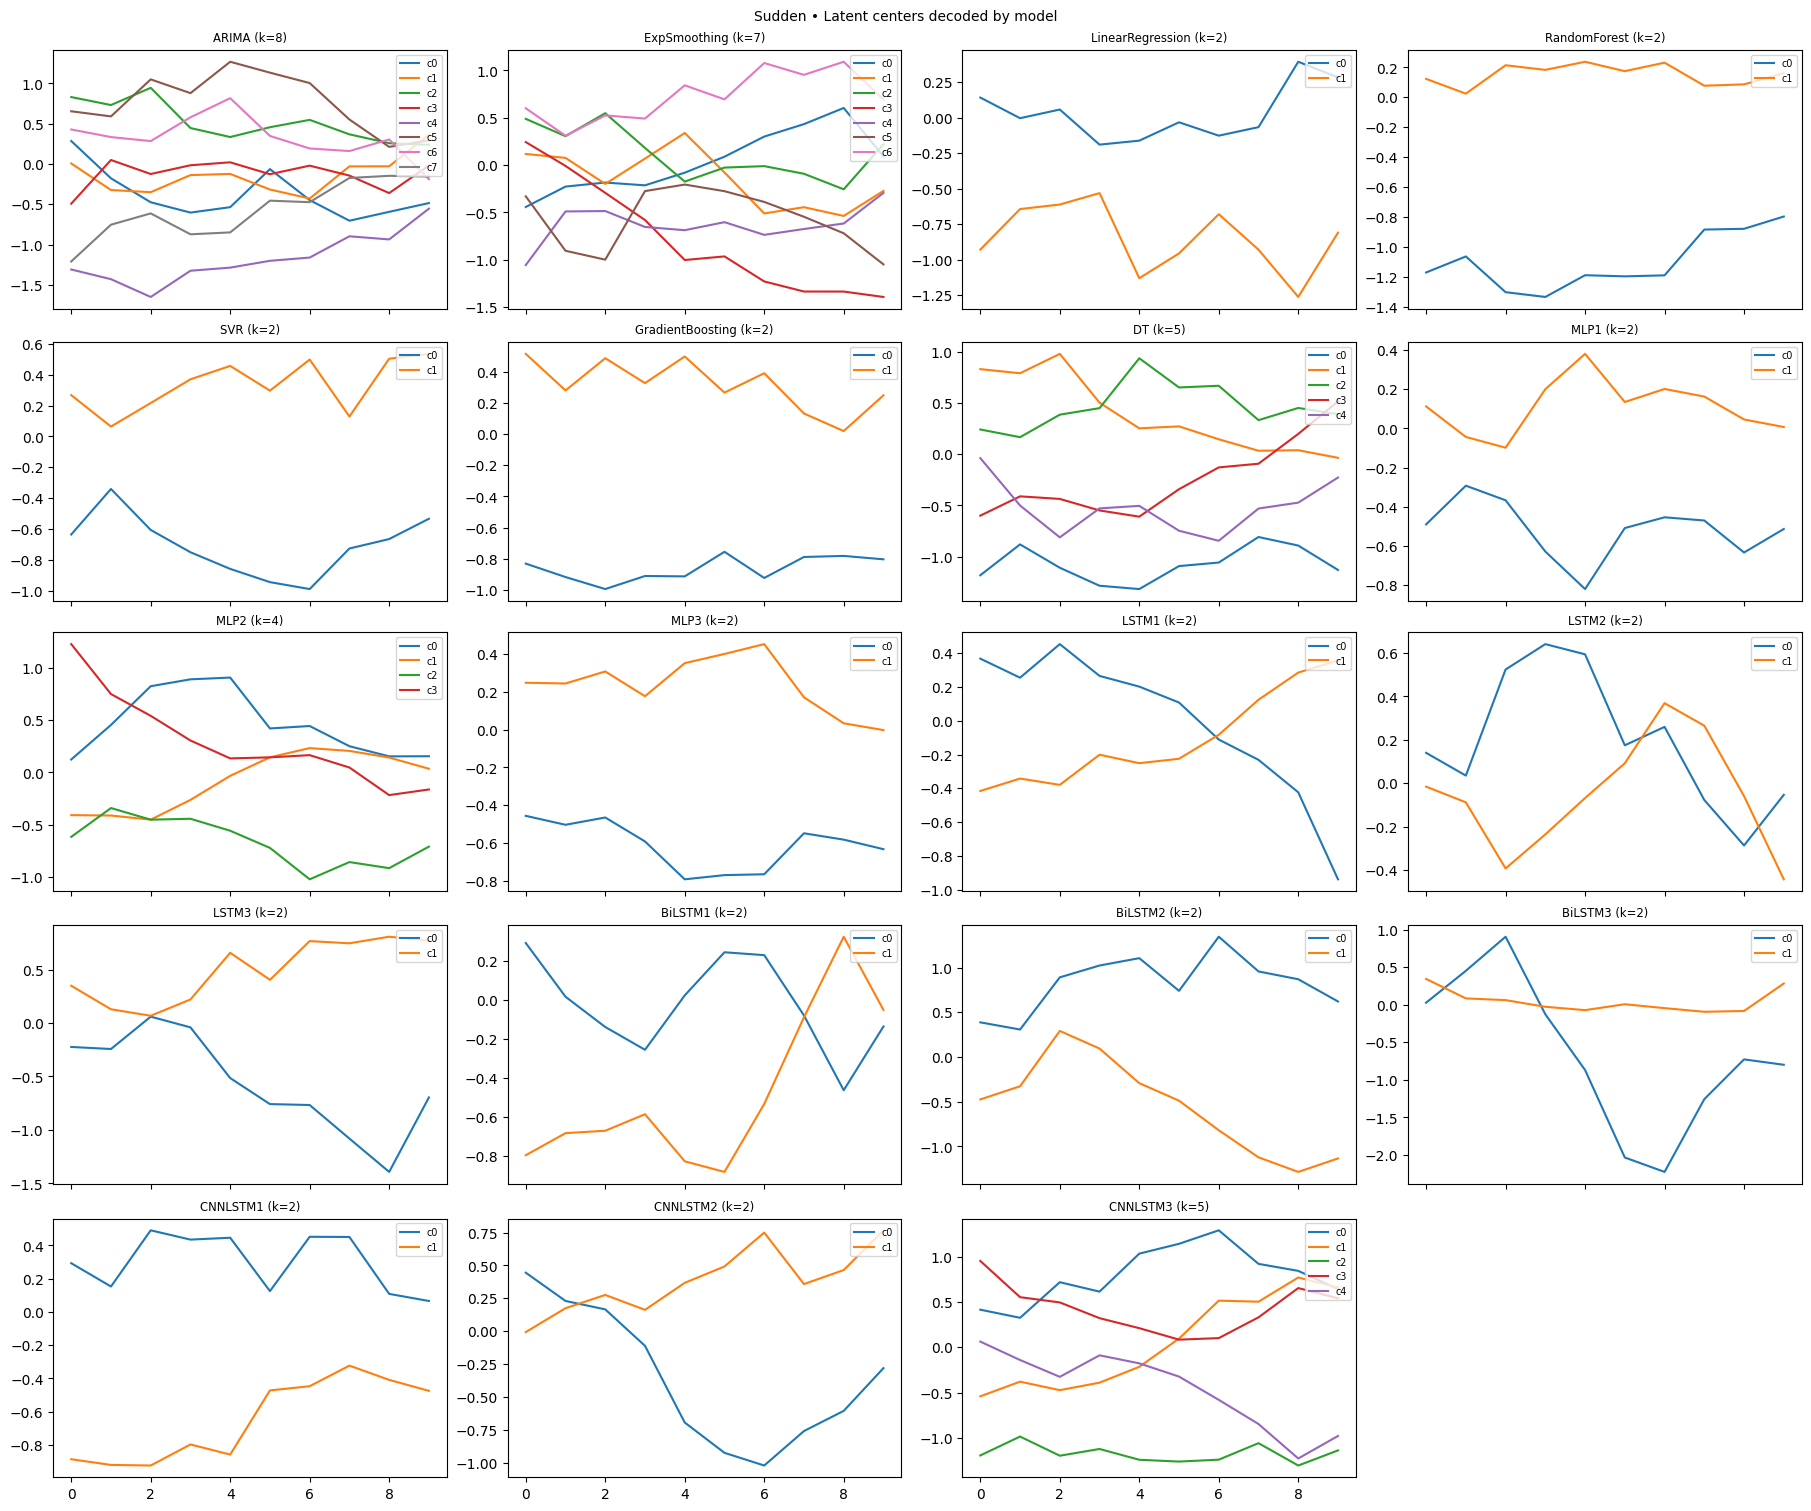


=== Compute K-means centers for Gradual (window_size=10) ===


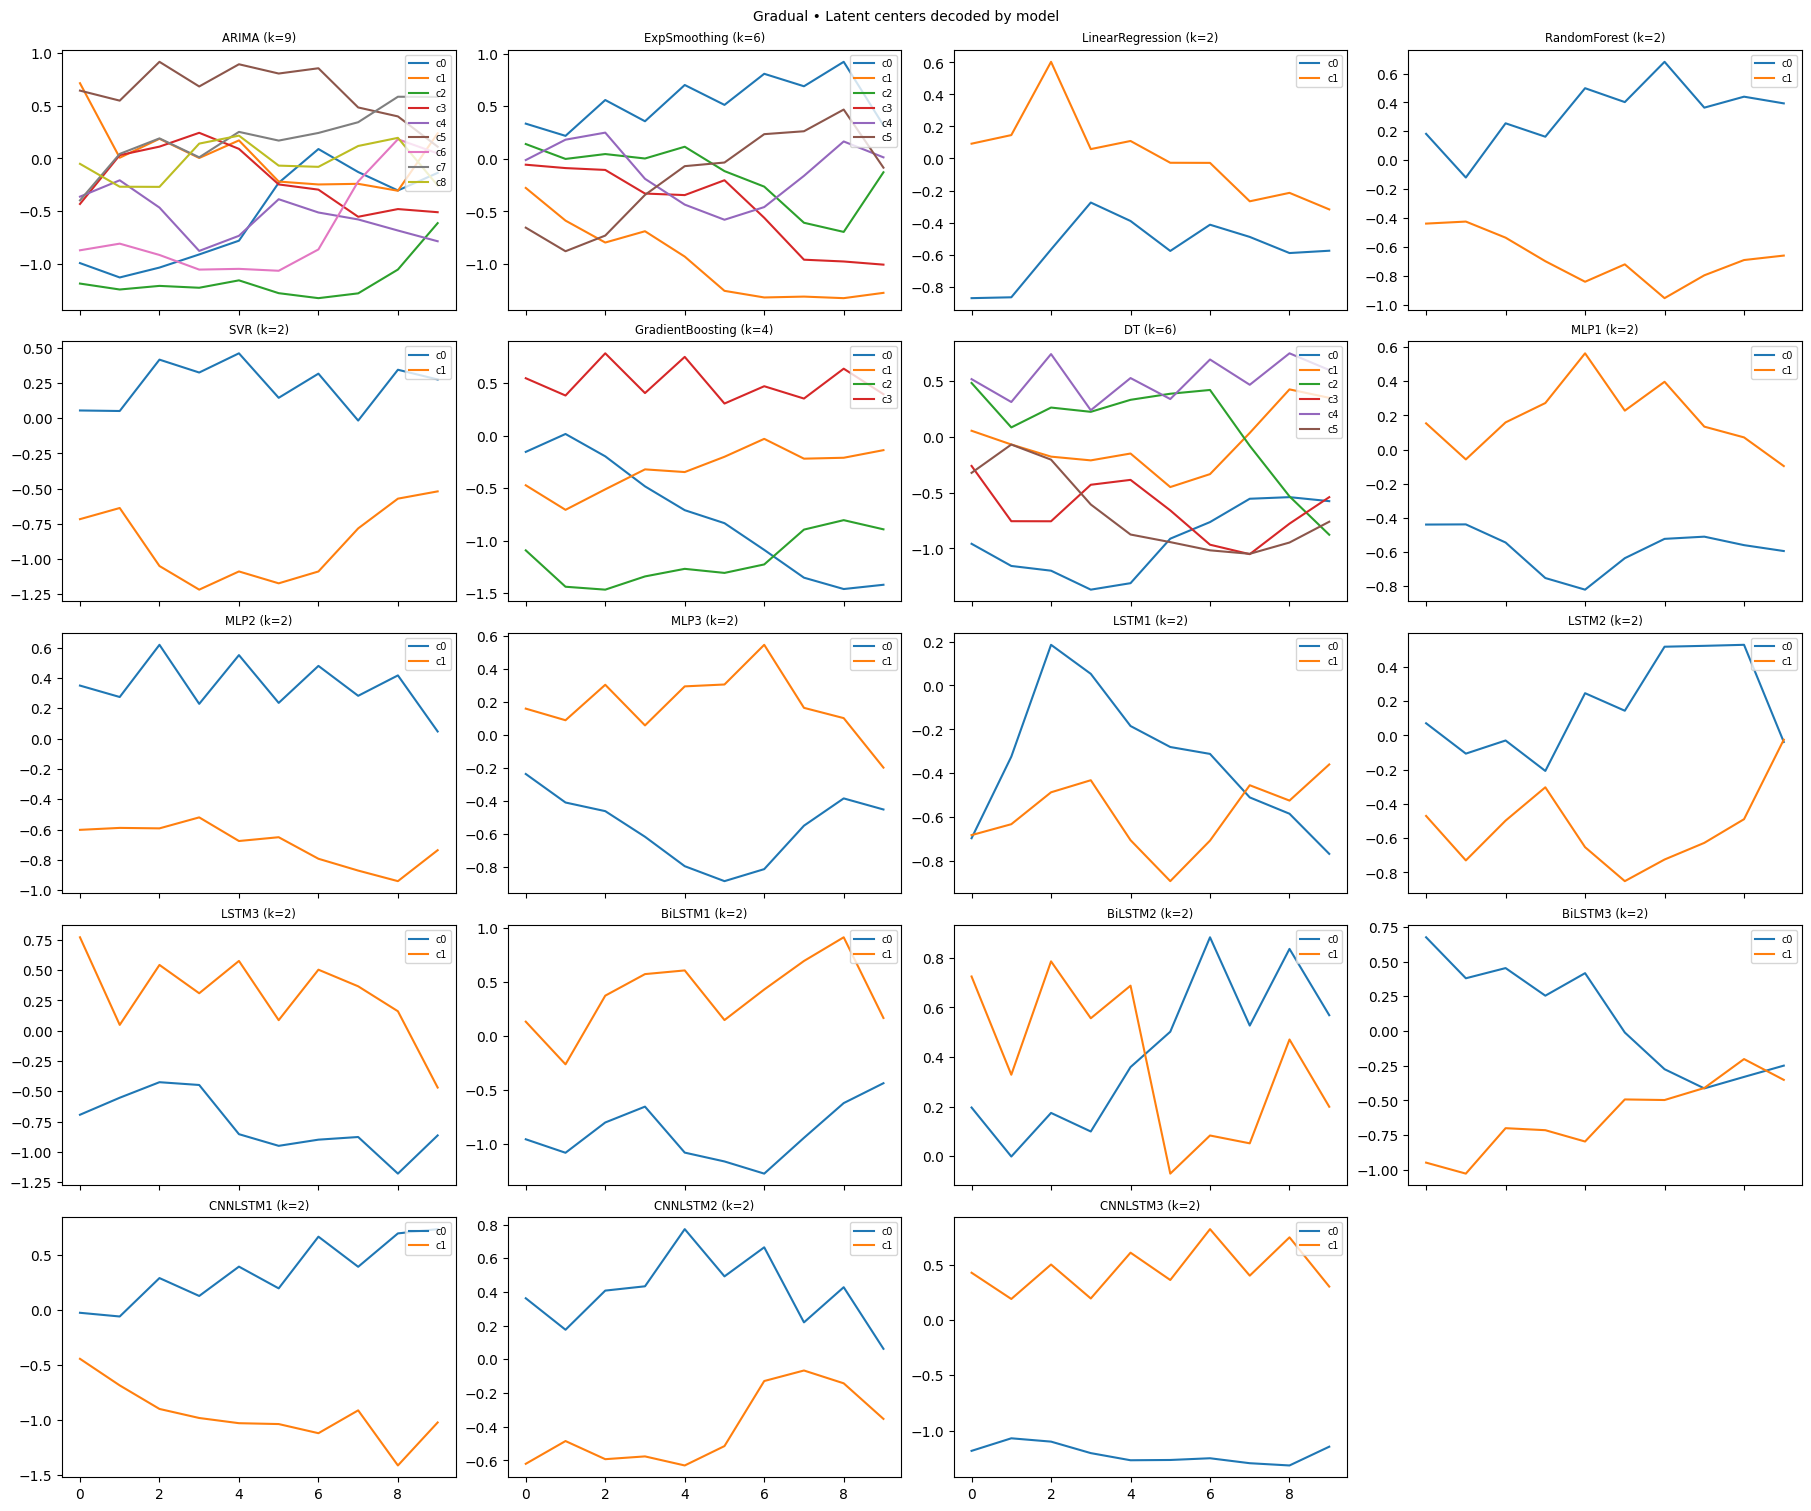


=== Compute K-means centers for Mixed (window_size=10) ===


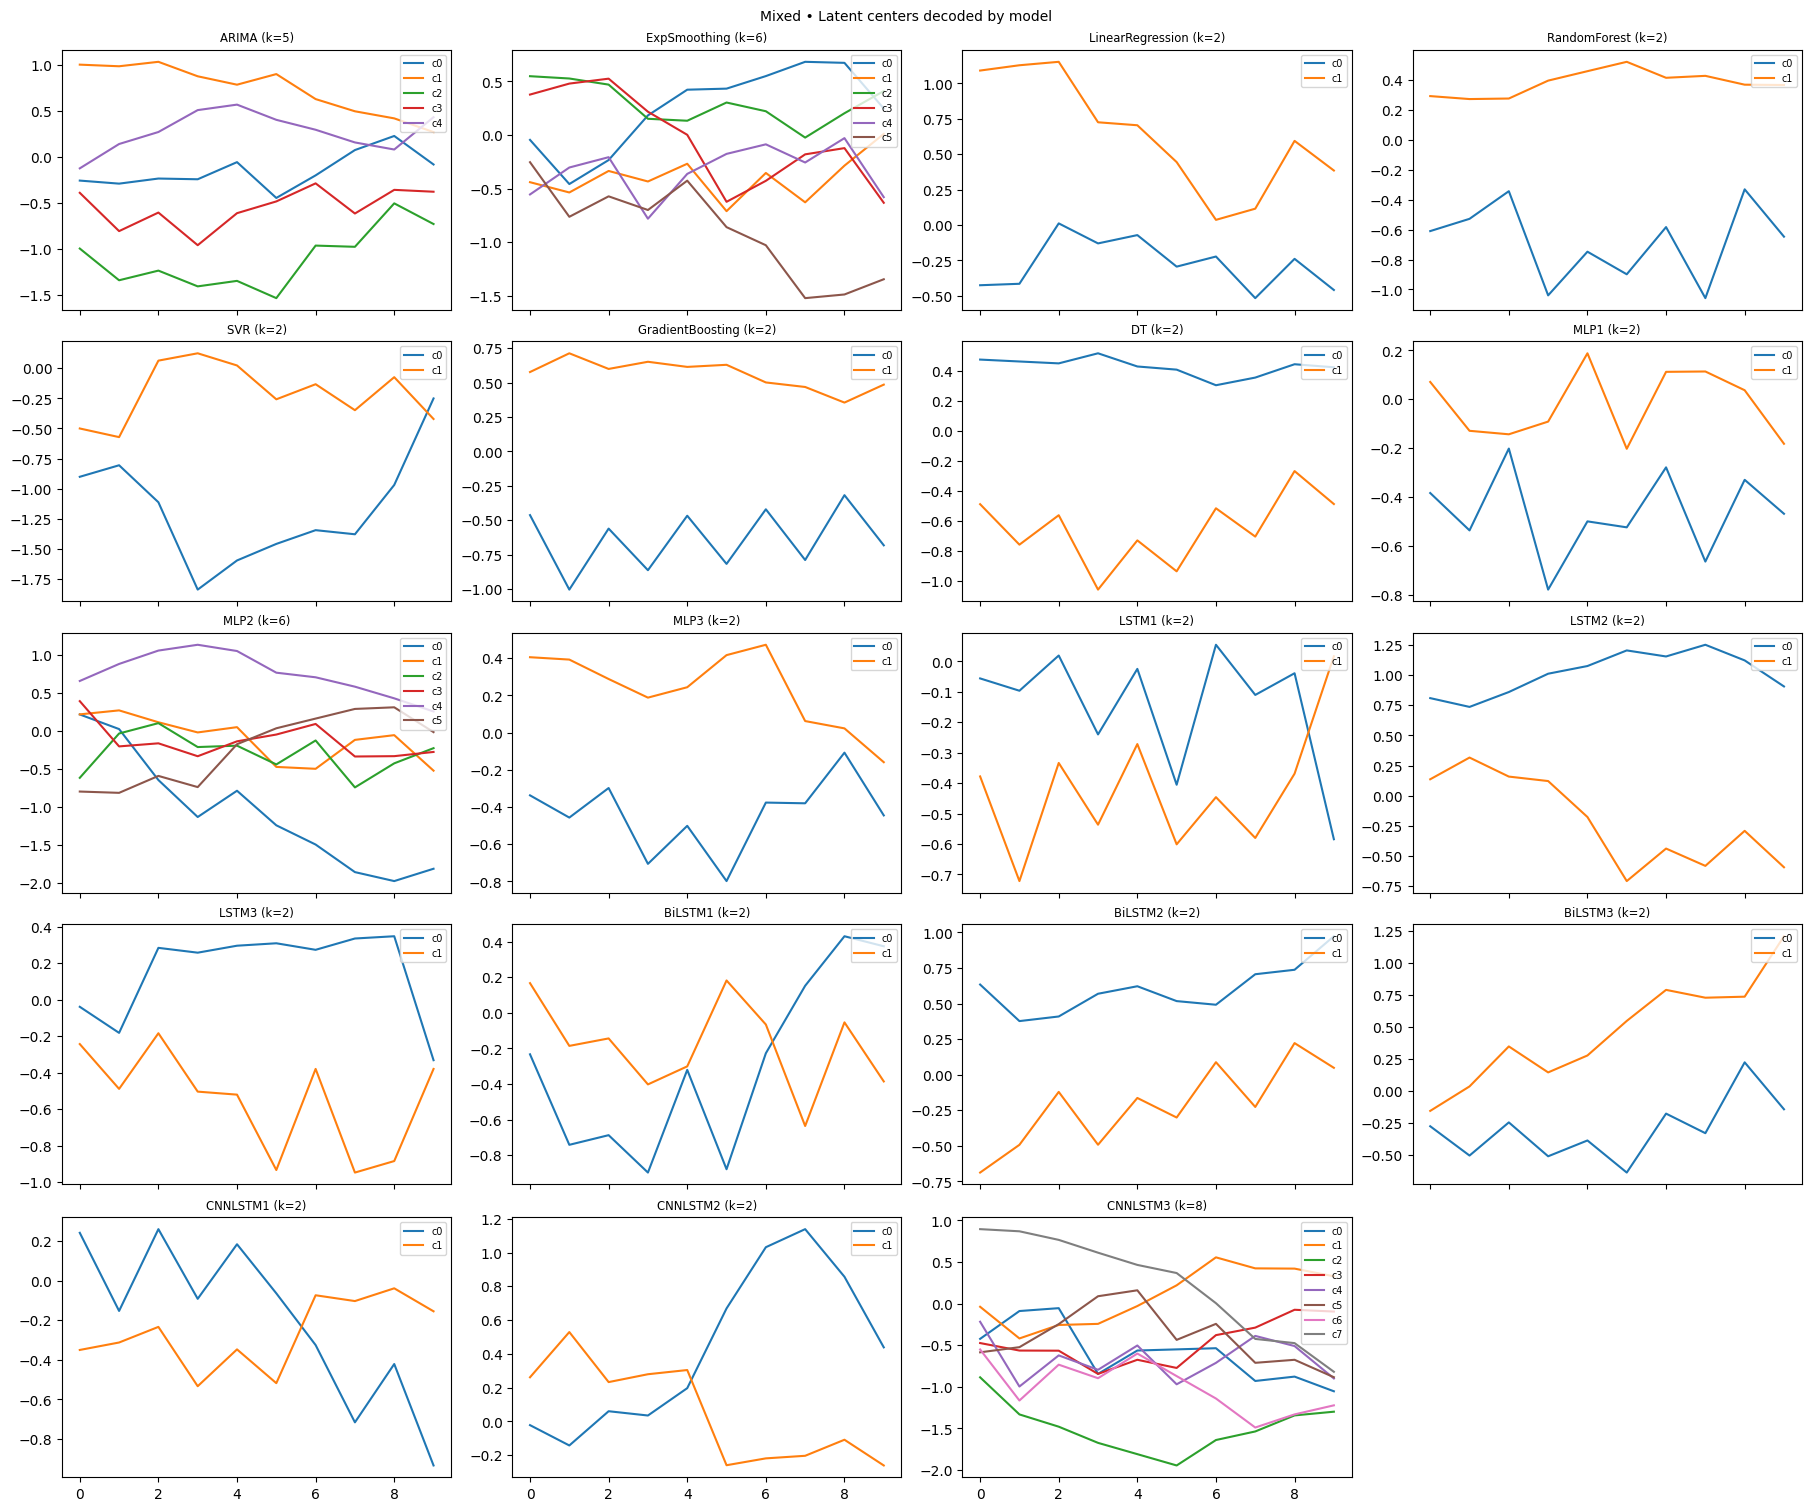

In [8]:
n_cols = 4
print(f"Bottleneck size: {latent_dim}")
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Compute K-means centers for {ds_name} (window_size={window_size}) ===")

    # Load models
    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    # Clear previous centers
    for model in forecasters.values():
        model.centers = {"raw": [], "latent": []}

    # Determine device for decoding latent centers
    decoder_device = next(ae.decoder.parameters()).device

    for name, model in forecasters.items():
        # Cluster latent RoCs
        N_latent = len(model.rocs["latent"])
        if N_latent > 0:
            k_max_latent = np.sqrt(N_latent / 2)
            model.compute_kmeans_centers(mode="latent", k_max=k_max_latent, random_state=seed)

        # Cluster raw RoCs
        N_raw = len(model.rocs["raw"])
        if N_raw > 0:
            k_max_raw = np.sqrt(N_raw / 2)
            model.compute_kmeans_centers(mode="raw", k_max=k_max_raw, random_state=seed)

    # Plot all latent cluster centers (decoded)
    names = [n for n in forecasters if len(forecasters[n].centers["latent"]) > 0]
    n_models = len(names)
    if n_models == 0:
        print(" No models have centers to plot.")
        continue

    n_rows = math.ceil(n_models / n_cols)

    fig_width = n_cols * 4.5
    fig_height = n_rows * 3

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(fig_width, fig_height),
                             sharex=True, constrained_layout=True)
    axes = axes.flatten()

    for ax, name in zip(axes, names):
        model = forecasters[name]
        for idx, c in enumerate(model.centers["latent"]):
            # ensure tensor on correct device
            c_tensor = c if isinstance(c, torch.Tensor) else torch.tensor(
                c, dtype=torch.float32
            )
            c_batch = c_tensor.unsqueeze(0).to(decoder_device)  # shape (1, C, L)
            decoded = ae.decoder(c_batch)                       # -> (1, 1, window_size)
            ts_data = decoded.detach().cpu().numpy().flatten()
            ax.plot(ts_data, label=f"c{idx}")
        ax.set_title(f"{name} (k={len(model.centers['latent'])})", fontsize="small")
        ax.legend(loc="upper right", fontsize="x-small")

    # turn off any unused subplots
    for ax in axes[n_models:]:
        ax.axis("off")

    plt.suptitle(f"{ds_name} • Latent centers decoded by model", fontsize="medium")
    plt.show()


=== Plot latent cluster samples for Sudden (compact grid) ===


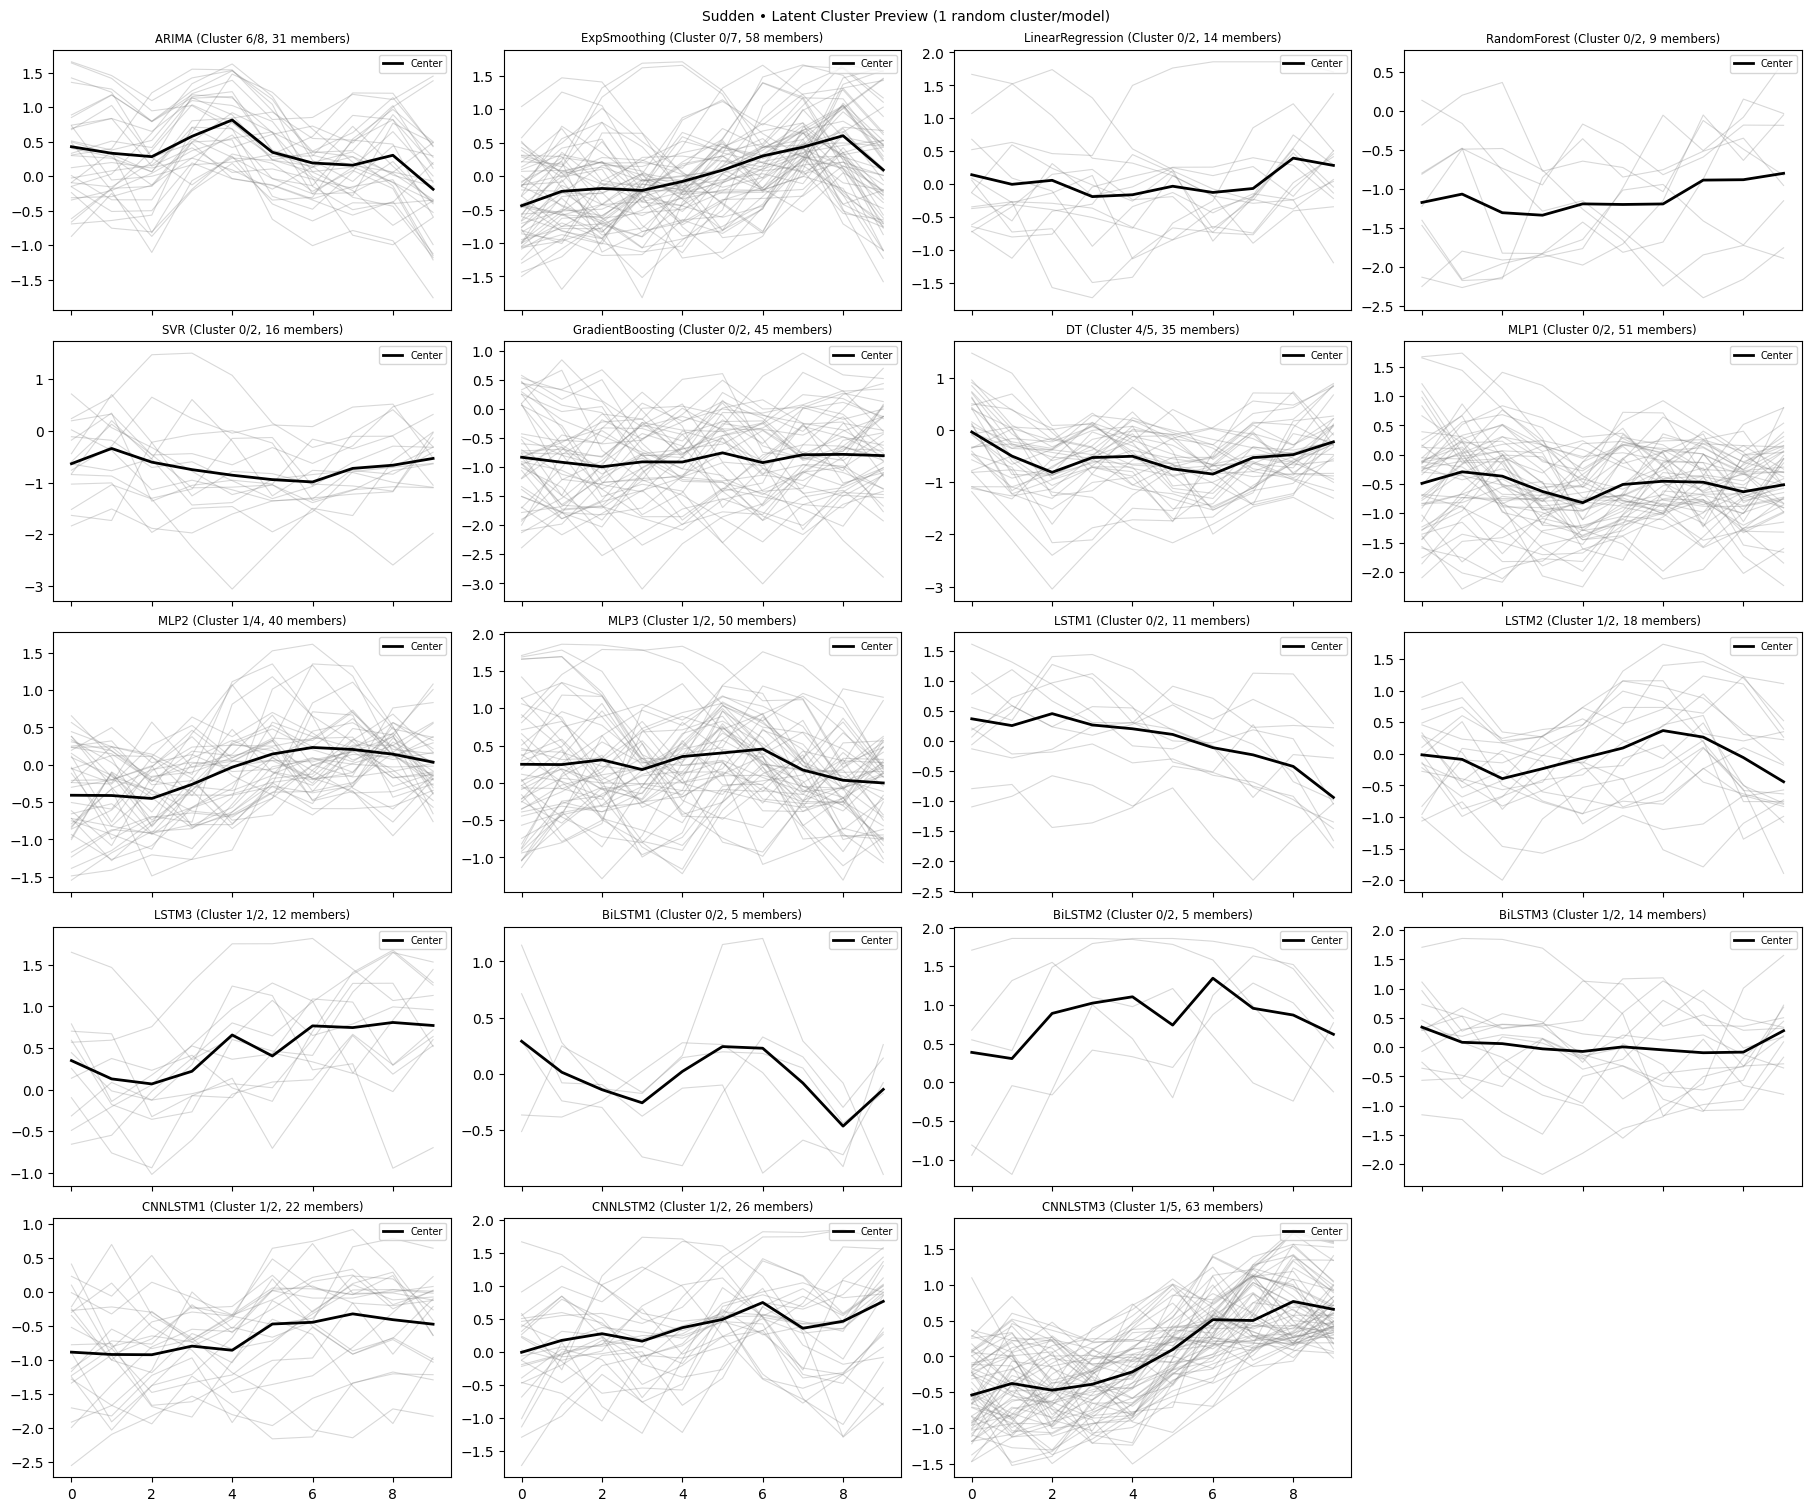


=== Plot latent cluster samples for Gradual (compact grid) ===


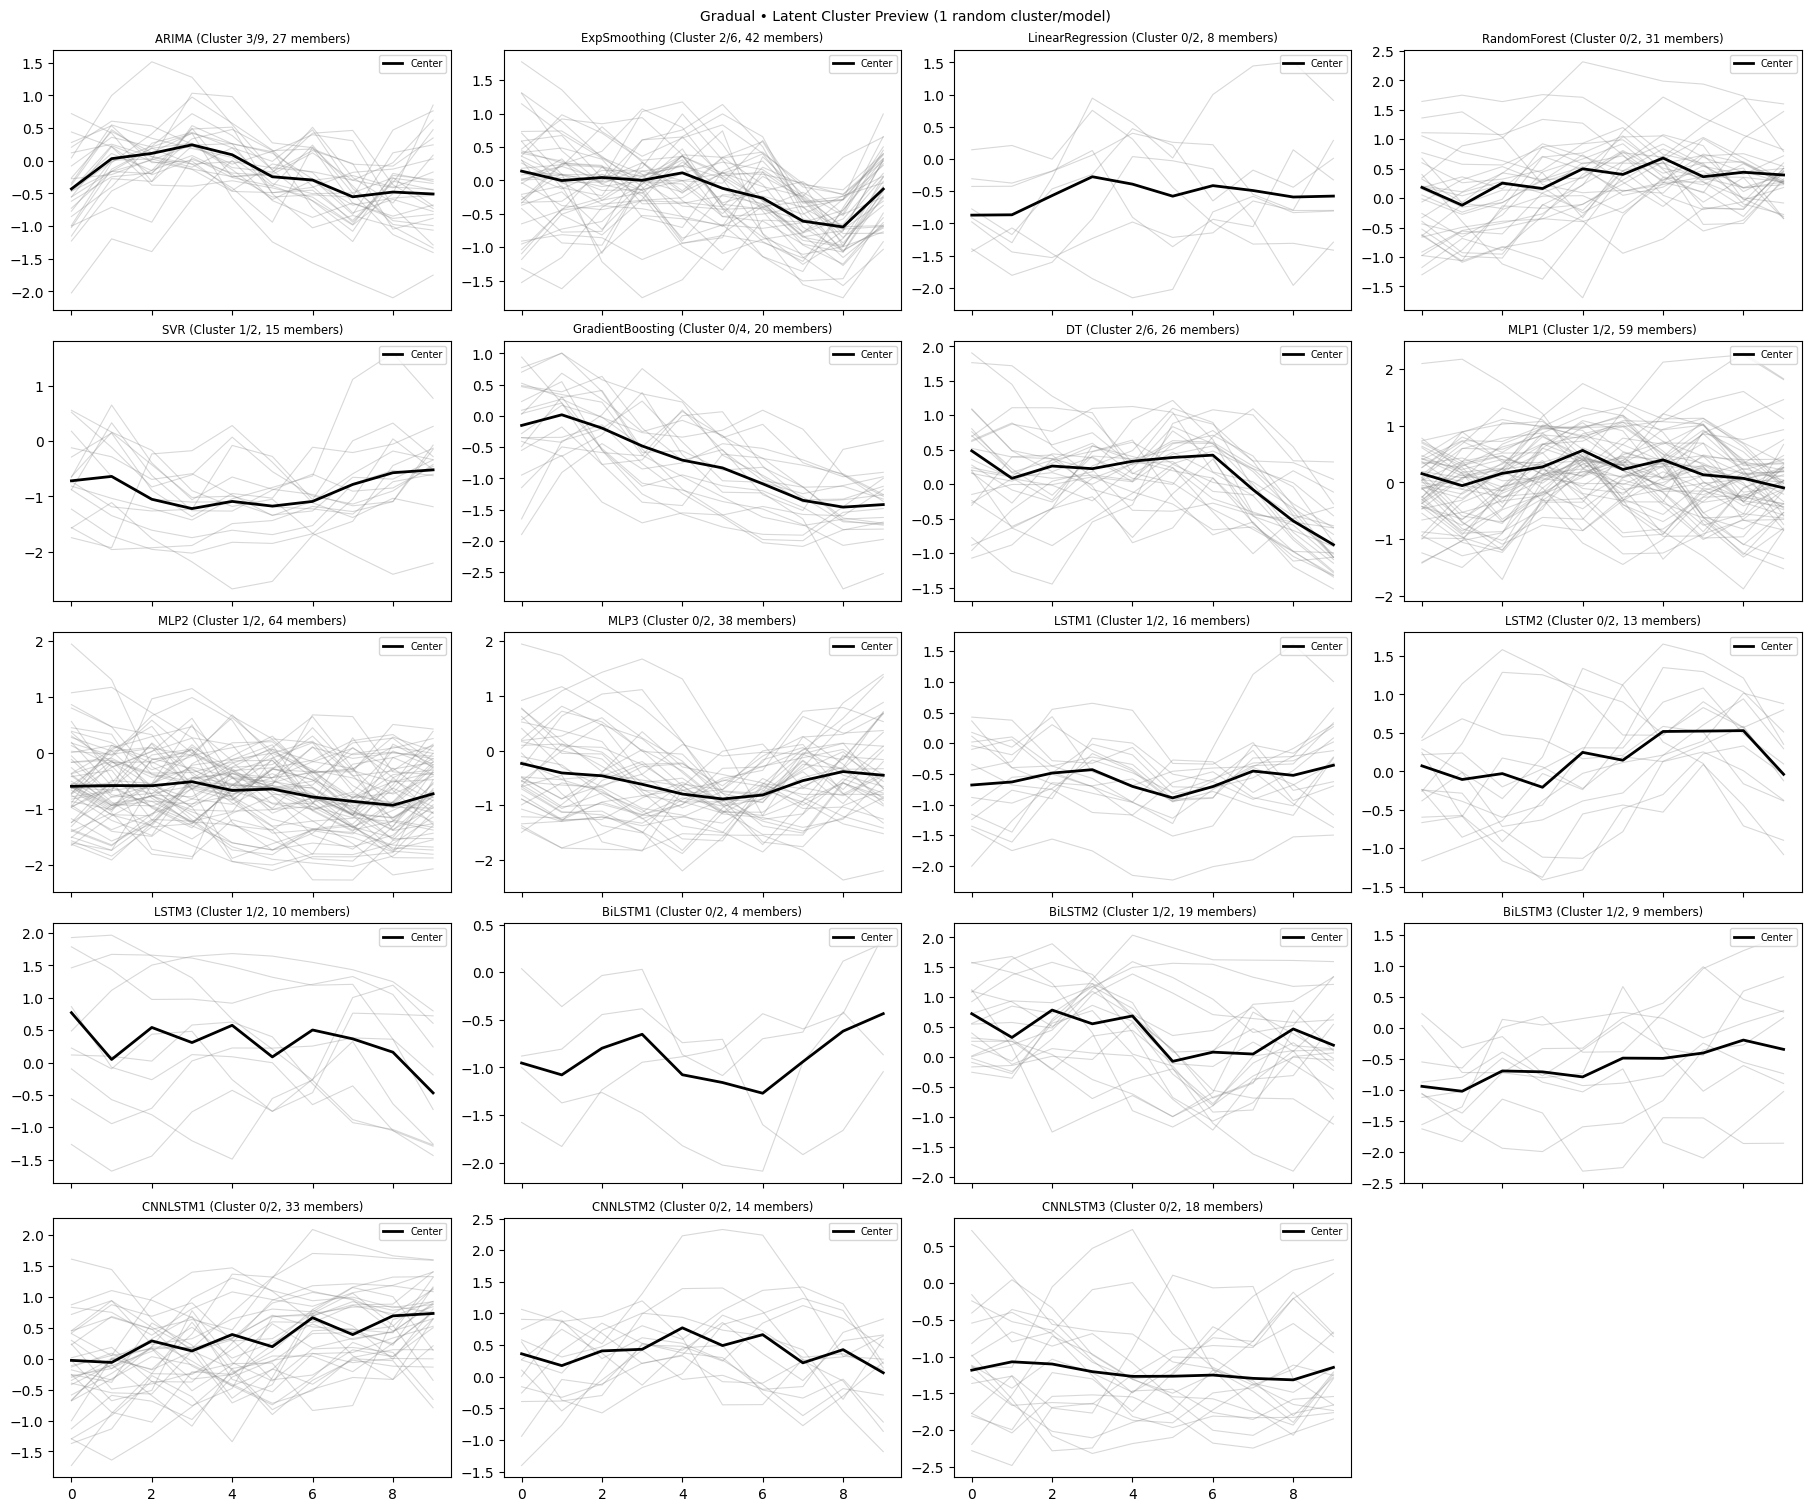


=== Plot latent cluster samples for Mixed (compact grid) ===


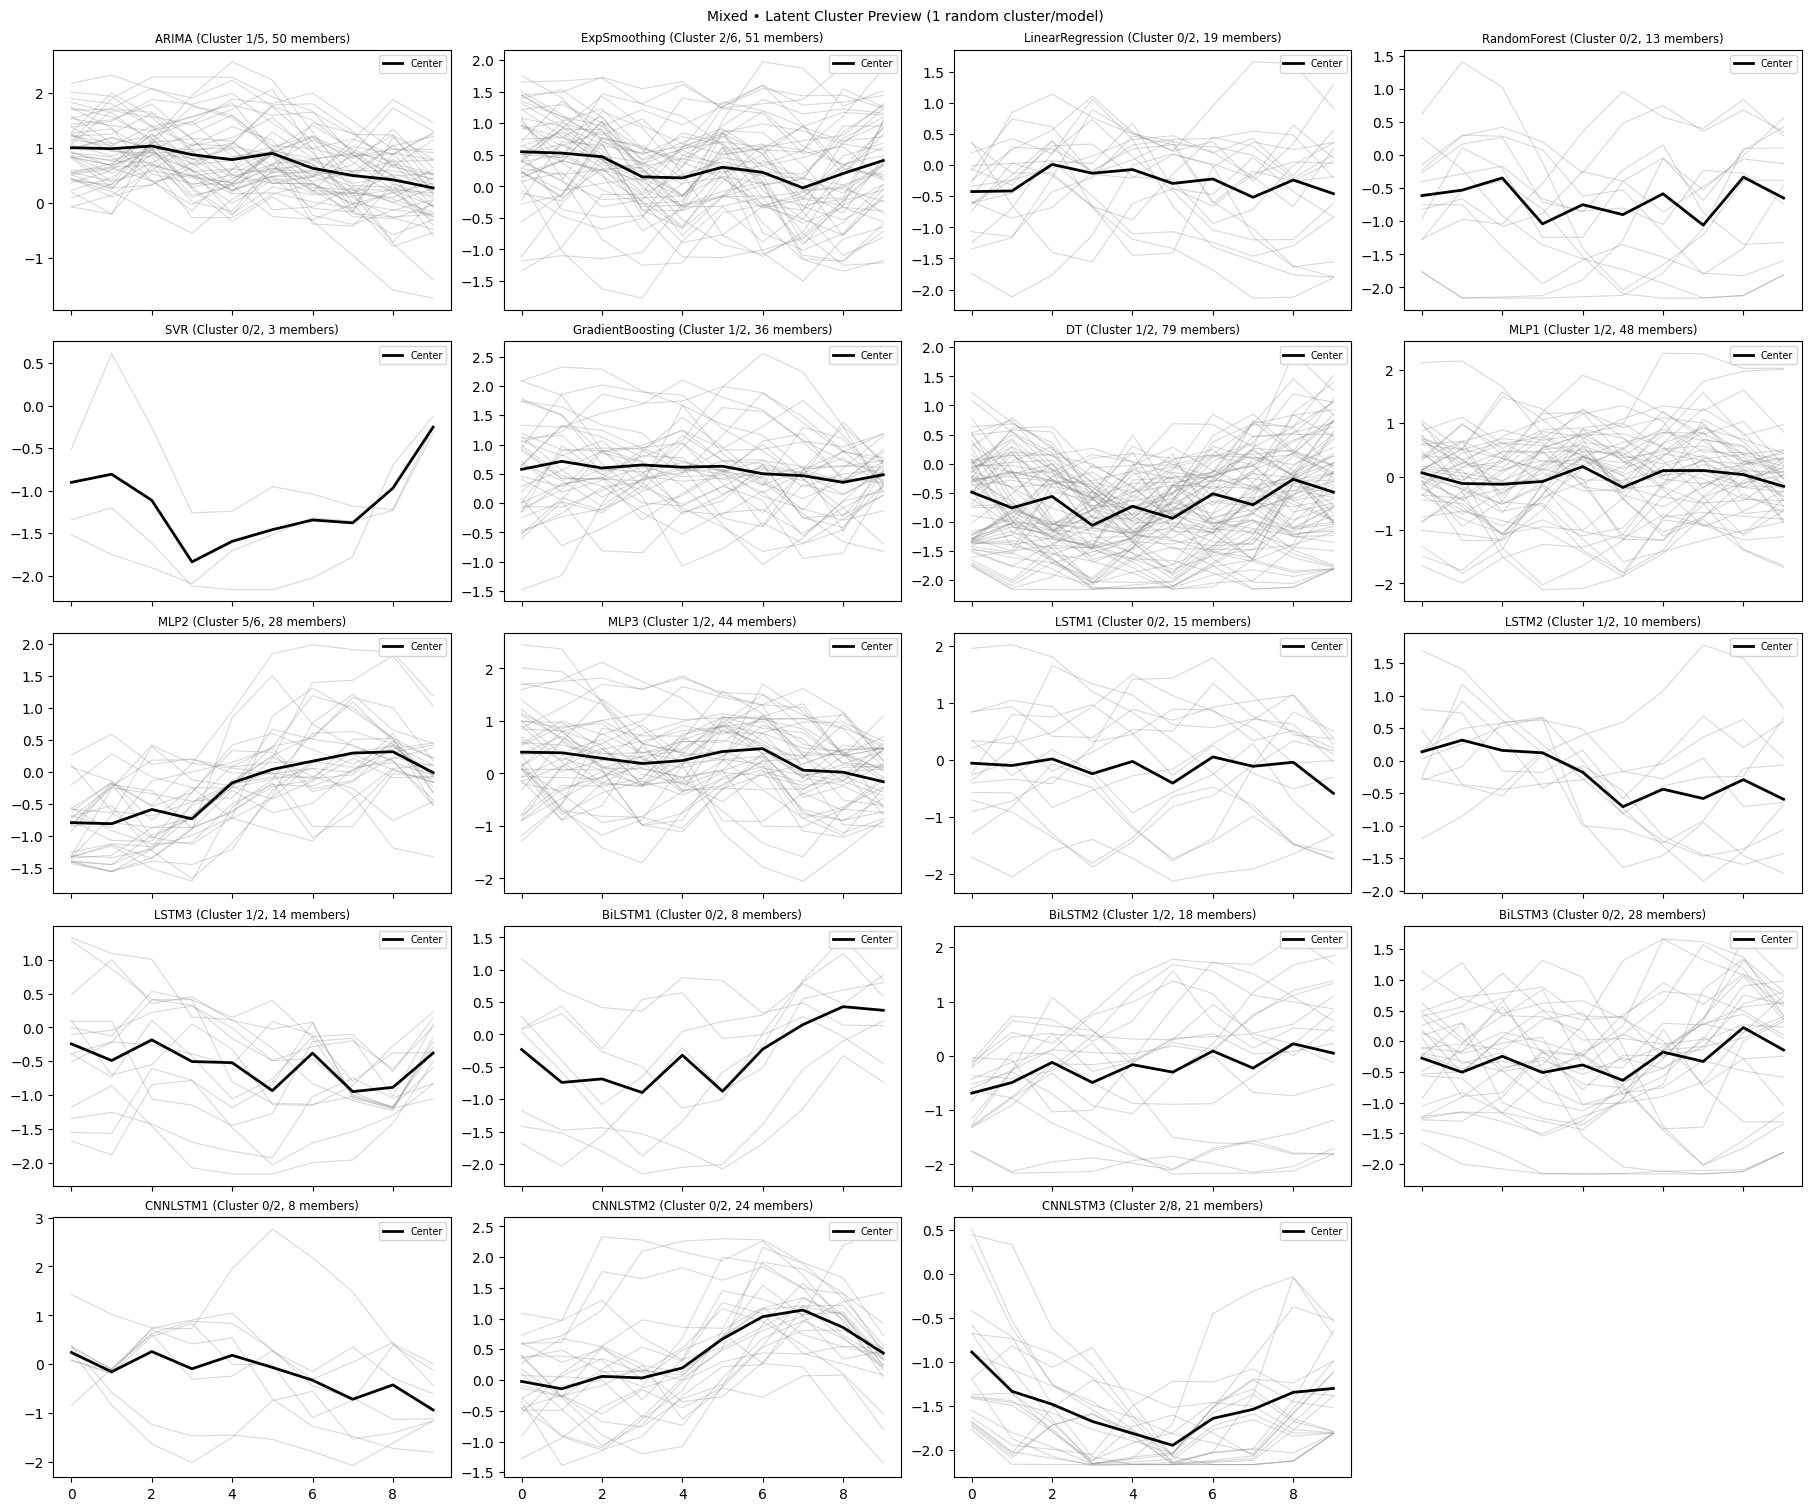

In [9]:
n_cols = 4
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Plot latent cluster samples for {ds_name} (compact grid) ===")

    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]
    decoder_device = next(ae.decoder.parameters()).device

    valid_models = []
    for name, model in forecasters.items():
        centers = model.centers["latent"]
        windows = model.rocs["latent"]

        if len(centers) == 0 or len(windows) == 0:
            continue

        # Flatten latent windows
        X = np.vstack([
            (w.detach().cpu().numpy() if isinstance(w, torch.Tensor) else np.array(w)).flatten()
            for w in windows
        ])

        # Flatten latent centers
        C = np.vstack([
            (c.detach().cpu().numpy() if isinstance(c, torch.Tensor) else np.array(c)).flatten()
            for c in centers
        ])

        # Use KMeans.predict with existing centers
        km = KMeans(n_clusters=len(C), init=C, n_init=1, max_iter=1, random_state=seed)
        labels = km.fit_predict(X)

        # Group windows by cluster
        cluster_to_indices = {i: [] for i in range(len(C))}
        for idx, label in enumerate(labels):
            cluster_to_indices[label].append(idx)

        valid_models.append((name, model, centers, cluster_to_indices, windows))

    n_models = len(valid_models)
    if n_models == 0:
        print(" No valid models to plot.")
        continue

    n_rows = math.ceil(n_models / n_cols)

    fig_width = n_cols * 4.5
    fig_height = n_rows * 3

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(fig_width, fig_height),
                             sharex=True, constrained_layout=True)
    axes = axes.flatten()

    for ax, (name, model, centers, cluster_to_indices, windows) in zip(axes, valid_models):
        non_empty_clusters = [i for i, idxs in cluster_to_indices.items() if len(idxs) > 0]
        if not non_empty_clusters:
            ax.set_title(f"{name} (no populated clusters)", fontsize="small")
            ax.axis("off")
            continue

        chosen_c = random.choice(non_empty_clusters)
        member_indices = cluster_to_indices[chosen_c]

        for i in member_indices:
            w_tensor = windows[i].unsqueeze(0).to(decoder_device)
            decoded = ae.decoder(w_tensor).detach().cpu().numpy().flatten()
            ax.plot(decoded, alpha=0.3, linewidth=0.8, color='gray')

        c_tensor = centers[chosen_c].unsqueeze(0).to(decoder_device)
        decoded_center = ae.decoder(c_tensor).detach().cpu().numpy().flatten()
        ax.plot(decoded_center, color='black', linewidth=2, label="Center")

        ax.set_title(
            f"{name} (Cluster {chosen_c}/{len(centers)}, {len(member_indices)} members)",
            fontsize="small"
        )
        ax.legend(loc="upper right", fontsize="x-small")

    # Turn off unused axes
    for ax in axes[n_models:]:
        ax.axis("off")

    plt.suptitle(f"{ds_name} • Latent Cluster Preview (1 random cluster/model)",
                 fontsize="medium")
    plt.show()

In [10]:
def fine_tune_ae(ae, buffer, device, epochs=2, lr=1e-4):
    ae.train()
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()

    # Stack buffer into (batch, 1, window_size)
    X = torch.from_numpy(np.stack(buffer)).float().unsqueeze(1).to(device)

    for _ in range(epochs):
        optimizer.zero_grad()
        recon = ae(X)
        loss = loss_fn(recon, X)
        loss.backward()
        optimizer.step()

    ae.eval()

Bottleneck size: 2

=== Dataset: Sudden ===
  > Metric: euclidean
      → Fine-tuning AE after drift at t=5557 [PercentileReconstructionDriftDetector]
      → Fine-tuning AE after drift at t=5558 [ZScoreReconstructionDriftDetector]
      → Fine-tuning AE after drift at t=5936 [PercentileReconstructionDriftDetector]
      → Fine-tuning AE after drift at t=6527 [PercentileReconstructionDriftDetector]
    -> MSE: 4.7366


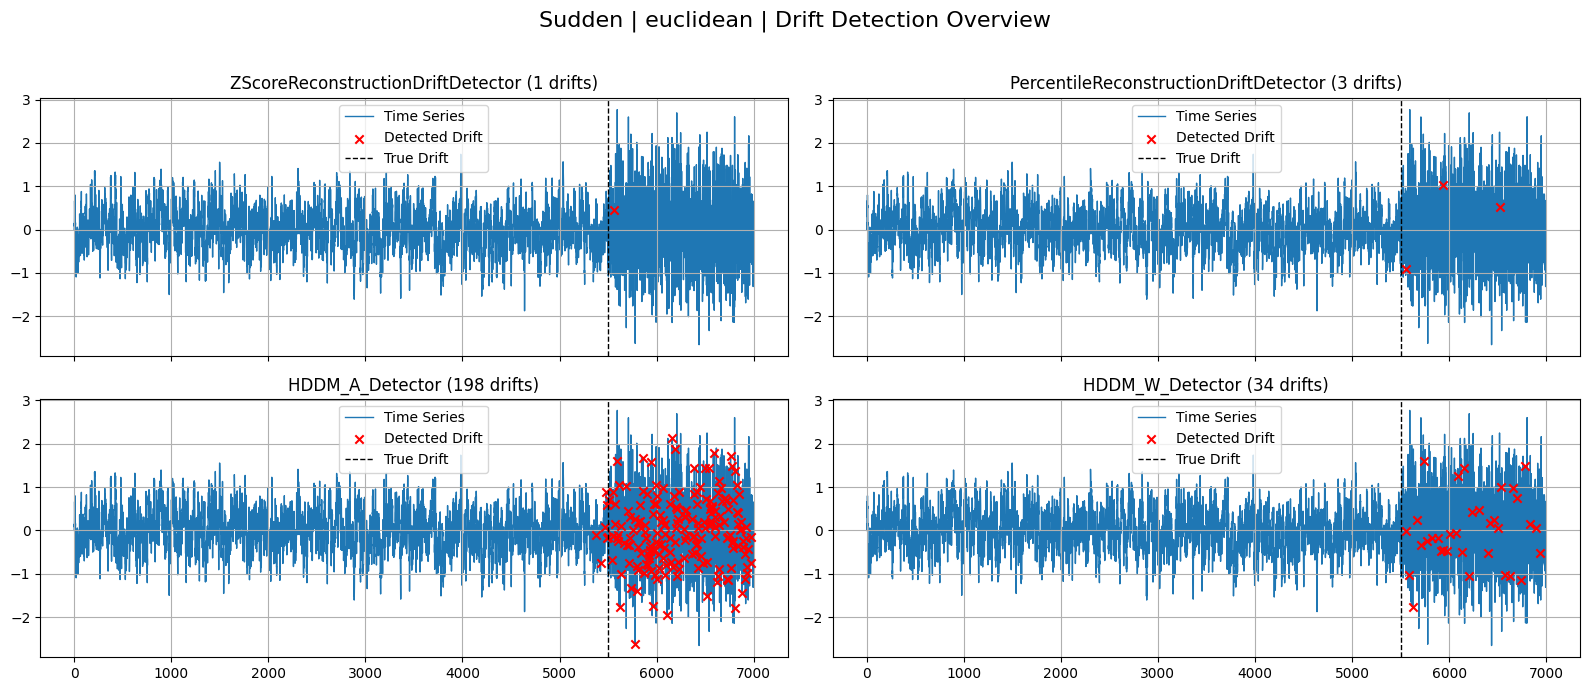


=== Dataset: Gradual ===
  > Metric: euclidean
      → Fine-tuning AE after drift at t=5565 [PercentileReconstructionDriftDetector]
      → Fine-tuning AE after drift at t=5596 [ZScoreReconstructionDriftDetector]
      → Fine-tuning AE after drift at t=5924 [PercentileReconstructionDriftDetector]
      → Fine-tuning AE after drift at t=5926 [ZScoreReconstructionDriftDetector]
      → Fine-tuning AE after drift at t=6785 [PercentileReconstructionDriftDetector]
    -> MSE: 3.4497


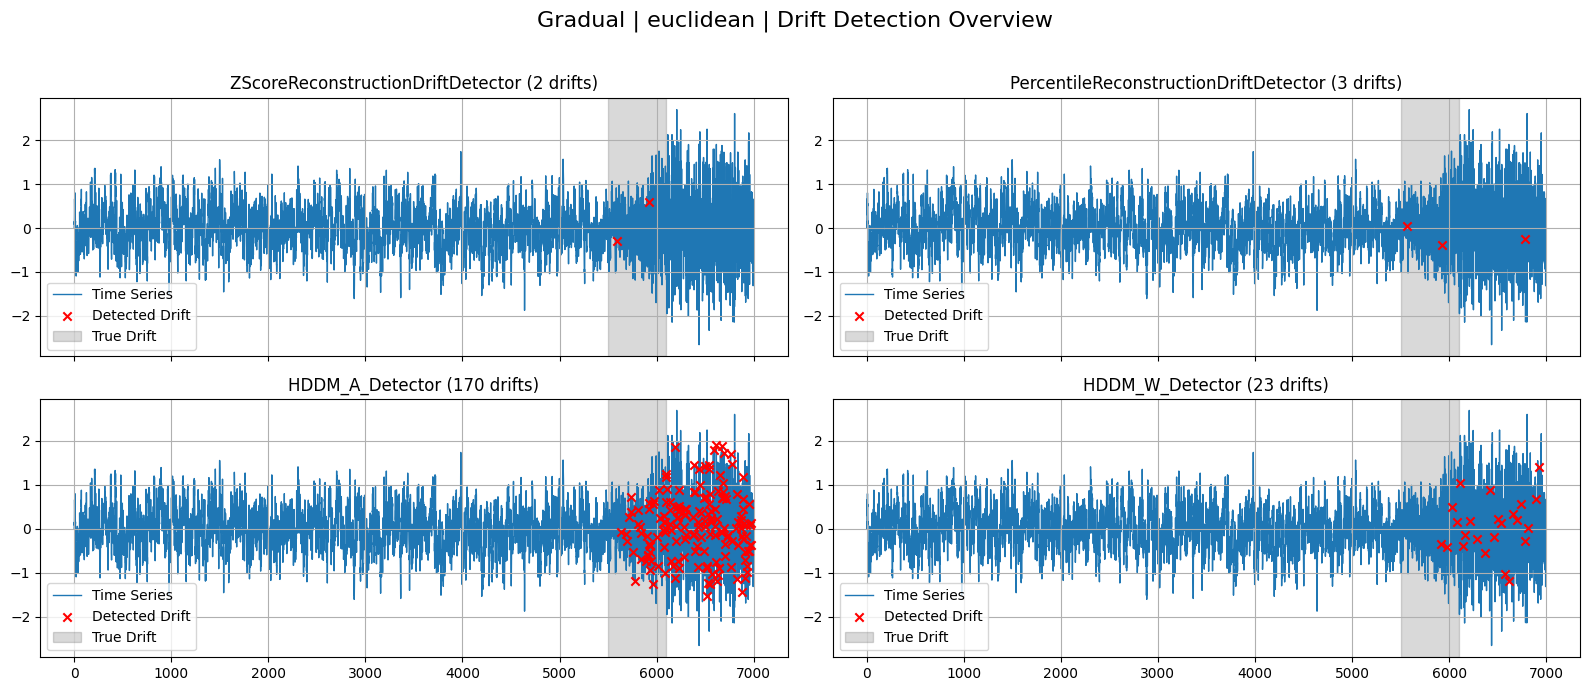


=== Dataset: Mixed ===
  > Metric: euclidean
      → Fine-tuning AE after drift at t=5556 [ZScoreReconstructionDriftDetector]
      → Fine-tuning AE after drift at t=5556 [PercentileReconstructionDriftDetector]
      → Fine-tuning AE after drift at t=5912 [PercentileReconstructionDriftDetector]
      → Fine-tuning AE after drift at t=6294 [PercentileReconstructionDriftDetector]
    -> MSE: 1.9565


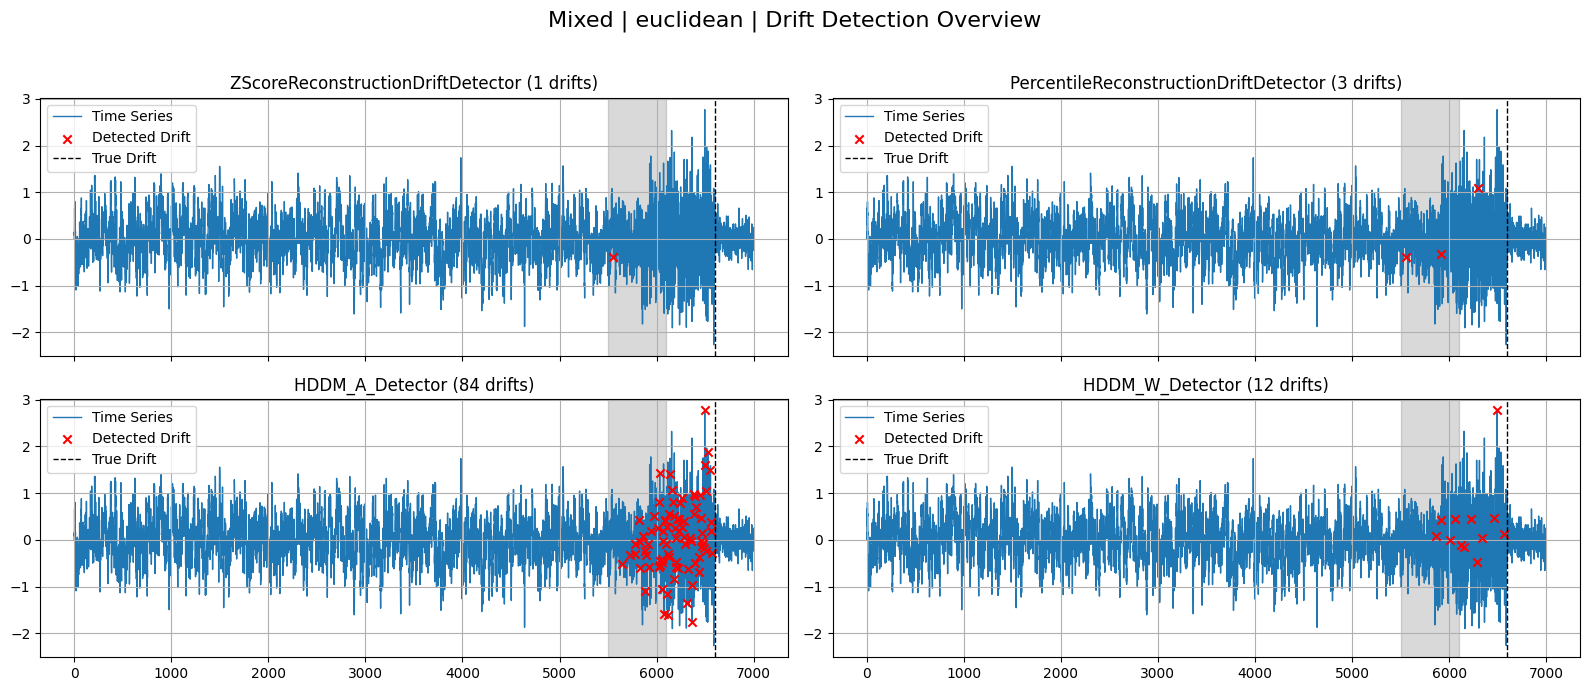

In [12]:
from collections import defaultdict

# Set the only metric to use
selected_metric = "euclidean"

# Ground truth drift points (by full-series index)
known_drifts = {
    "Sudden": [5500],
    "Gradual": [[5500, 6100]],
    "Mixed": [[5500, 6100], 6600], 
}

# Fine-tuning setup
window_buffer = []
fine_tune_buffer_size = 128

# Initialize detectors per dataset
detectors_per_ds = {}
for ds_name, *_ in ts_configs:
    detectors_per_ds[ds_name] = [
        ZScoreReconstructionDriftDetector(),
        PercentileReconstructionDriftDetector(),
        HDDM_A_Detector(),
        HDDM_W_Detector(),
    ]

print(f"Bottleneck size: {latent_dim}")

for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Dataset: {ds_name} ===")

    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    full_series = ts.data
    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]
    n_windows = len(X_test)
    device = next(ae.parameters()).device

    test_start = len(X_train) + len(X_val)  # where test windows begin in full series

    lat_preds = []
    recon_errors = []

    # Reset detectors and drift log
    detectors = detectors_per_ds[ds_name]
    for det in detectors:
        det.reset()
    drift_hits = defaultdict(list)  # full_idx → list of detector names

    print(f"  > Metric: {selected_metric}")
    for idx, w in enumerate(X_test):
        # Prepare AE input
        x_tensor = (
            torch.from_numpy(w).float()
            .unsqueeze(0).unsqueeze(1)
            .to(device)
        )

        with torch.no_grad():
            recon = ae(x_tensor).squeeze().cpu().numpy()
            recon_error = np.mean((w - recon) ** 2)
            recon_errors.append(recon_error)

            q = ae.encoder(x_tensor).squeeze(0).cpu()

        # Latent distance-based model selection
        best_name, best_dist = None, float("inf")
        for name, model in forecasters.items():
            for entry in model.rocs["latent"]:
                d = compute_distance(q, entry, metric=selected_metric)
                if d < best_dist:
                    best_dist = d
                    best_name = name

        pred = forecasters[best_name].predict(w)
        lat_preds.append(pred)

        # Translate test window index to full series index
        full_idx = test_start + idx + window_size - 1

        # Update buffer
        window_buffer.append(w)
        if len(window_buffer) > fine_tune_buffer_size:
            window_buffer.pop(0)

        # Compute prediction error (for HDDM)
        mse_error = (y_test[idx] - pred) ** 2

        for detector in detectors:
            if isinstance(detector, (HDDM_A_Detector, HDDM_W_Detector)):
                triggered = detector.update(mse_error, idx)
            else:
                triggered = detector.update(recon_error, idx)

            if triggered:
                drift_hits[full_idx].append(detector.__class__.__name__)
                if len(window_buffer) >= fine_tune_buffer_size and not isinstance(detector, (HDDM_A_Detector, HDDM_W_Detector)):
                    print(f"      → Fine-tuning AE after drift at t={full_idx} [{detector.__class__.__name__}]")
                    fine_tune_ae(ae, window_buffer, device)

    # Print MSE
    mse_lat = mean_squared_error(y_test, lat_preds)
    print(f"    -> MSE: {mse_lat:.4f}")

    # --- Compact Grid Plot ---
    n = len(detectors)
    n_cols = 2
    n_rows = (n + n_cols - 1) // n_cols

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 3.5 * n_rows), sharex=True)
    axs = axs.flatten()

    for i, detector in enumerate(detectors):
        detector_name = detector.__class__.__name__
        drift_indices = [idx for idx, names in drift_hits.items() if detector_name in names]

        axs[i].plot(full_series, label="Time Series", linewidth=1, zorder=1)

        # Detected drift points
        if drift_indices:
            axs[i].scatter(
                drift_indices,
                [full_series[i] for i in drift_indices],
                color='red', marker='x', label='Detected Drift', zorder=2
            )

        # Ground-truth drift points or ranges
        if ds_name in known_drifts:
            for d in known_drifts[ds_name]:
                if isinstance(d, list) and len(d) == 2:
                    axs[i].axvspan(d[0], d[1], color='black', alpha=0.15, label='True Drift', zorder=0)
                else:
                    axs[i].axvline(d, color='black', linestyle='--', linewidth=1,
                                   label='True Drift', zorder=3)

        # Unique legend
        handles, labels = axs[i].get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        axs[i].legend(by_label.values(), by_label.keys())

        axs[i].set_title(f"{detector_name} ({len(drift_indices)} drifts)")
        axs[i].grid(True)

    # Hide unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis("off")

    fig.suptitle(f"{ds_name} | {selected_metric} | Drift Detection Overview", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()